In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
%matplotlib inline
import seaborn as sns
import math
import ast
import progressbar
import os

# import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import LinearSegmentedColormap
import statsmodels.formula.api as smf

# Cleaning Dataset (todo in P3 main file)

In [40]:
actors = pd.read_pickle("./data/actors.pkl")
movies = pd.read_pickle("./data/movies.pkl").set_index('IMDb_ID')

actors_movies = actors.droplevel(0, axis=1).merge(movies['averageRating'],left_on='IMDb_ID', right_index=True)
actors_movies = actors_movies.drop(columns=['birthYear', 'movie_count_genre'])
actors_movies = actors_movies.replace("\\N", pd.NA)

In [41]:
# Input:
#   - year (int)
#   - range (int)
# Output:
#   - Range (str)
def create_range(year, range=10):
    start_range = (year // range) * range
    return "{} - {}".format(start_range, start_range + range)


actors_movies = actors_movies.sort_values(by='Movie release date')
actors_movies['ReleaseYearRange'] = actors_movies['Movie release date'].apply(lambda x: create_range(x))

In [42]:
# Calculate the 30th and 70th percentiles
low_threshold = actors_movies['averageRating'].quantile(0.3)
high_threshold = actors_movies['averageRating'].quantile(0.7)

# Filter the DataFrame to keep only the rows in the lowest 30% and highest 30%
actors_movies = actors_movies[(actors_movies['averageRating'] <= low_threshold) | (actors_movies['averageRating'] >= high_threshold)]

In [43]:
display(actors_movies)

,,ordering,Wikipedia movie ID,Movie name,Movie release date,primaryName,awards,nominations,movie_count,genres_b4,IsDrama,isMale,age_at_release,averageRating,ReleaseYearRange
IMDb_ID,IMDb_actor_ID,,,,,,,,,,,,,,
tt0021324,nm0000802,1,5884622,The Runaway Bride,1930,Mary Astor,0,0,1,7,0,0,24,4.9,1930 - 1940
tt0021233,nm0823597,1,32828818,Pardon My Gun,1930,Sally Starr,0,0,1,1,0,0,21,4.3,1930 - 1940
tt0020690,nm0002001,1,142837,The Big Pond,1930,Maurice Chevalier,0,1,1,7,0,1,42,5.7,1930 - 1940
tt0021148,nm0237597,1,177741,Min and Bill,1930,Marie Dressler,0,0,1,4,1,0,62,6.7,1930 - 1940
tt0021493,nm0949835,1,28197079,The Truth About Youth,1930,Loretta Young,0,0,1,4,1,0,17,5.6,1930 - 1940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
tt1430811,nm1883440,1,33650887,Deadline,2012,Steve Talley,0,0,1,1,1,1,31,4.8,2010 - 2020
tt2351177,nm3054665,1,35279558,Bhooter Bhabishyat,2012,Swastika Mukherjee,0,0,1,1,0,0,32,8.1,2010 - 2020
tt1623288,nm2240346,1,31804949,ParaNorman,2012,Kodi Smit-McPhee,0,0,2,7,0,1,16,7.0,2010 - 2020


# First analysis using t-test

In [44]:
# - ttest pour chaque feature sur toutes années confondues (6 ttest) (Armance)
#     - voire influence generale

# Text résumant les résultats

# Visualizing the evolution of features over time

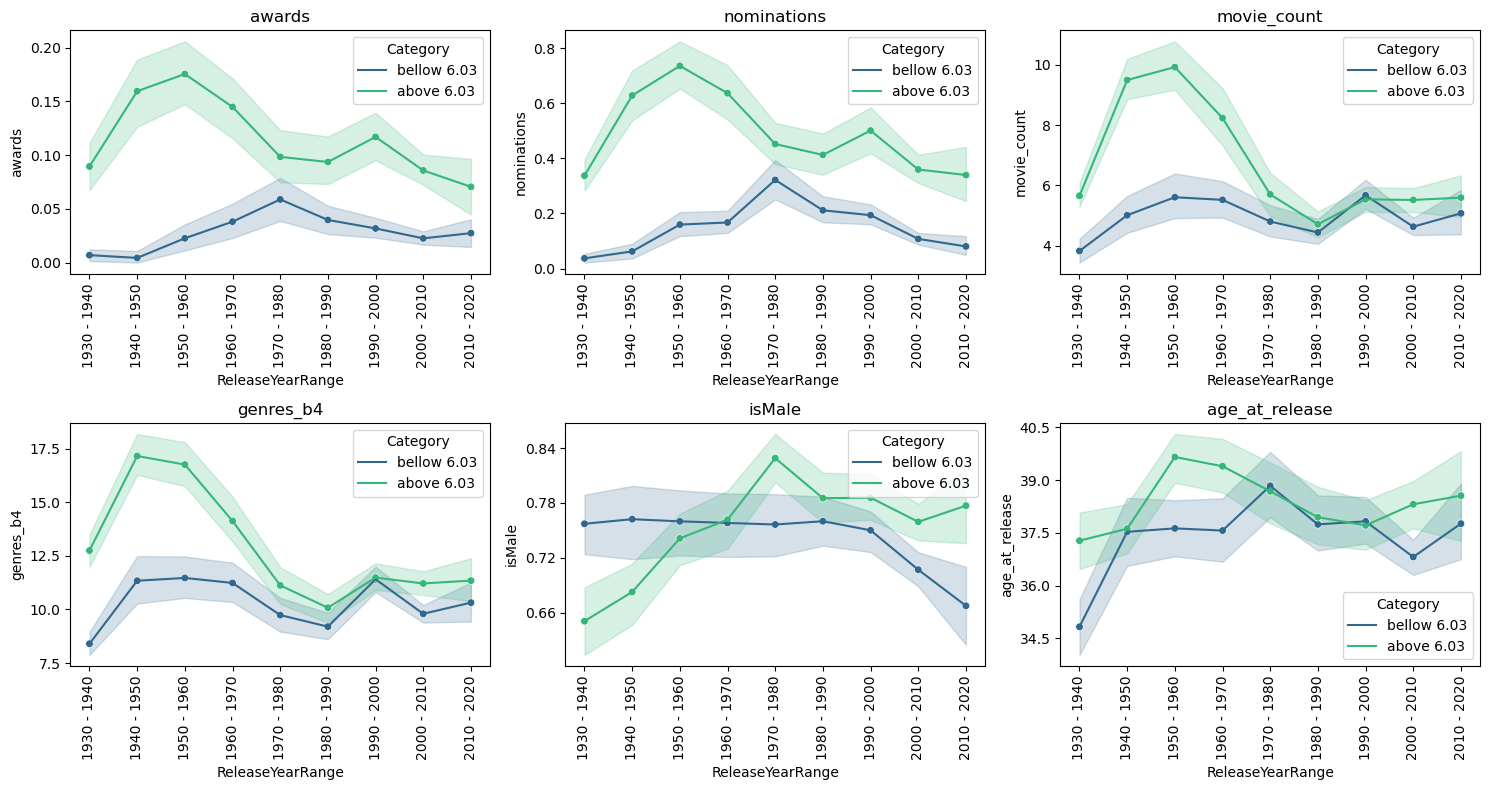

In [45]:
def do_fancy_ecpi_cute_plot(df, cat, diff, x, y_list, titles, ncols=3, max_y_ticks=5):

    nrows = -(-len(y_list) // ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))

    lo = df.query(f'{diff} < @{cat}').copy()
    hi = df.query(f'{diff} >= @{cat}').copy()
    # me = df.copy()
    
    lo.loc[:, 'Category'] = 'bellow {}'.format(globals()[cat])
    hi.loc[:, 'Category'] = 'above {}'.format(globals()[cat])
    # me.loc[:, 'Category'] = 'mean'

    for i, (y, title) in enumerate(zip(y_list, titles)):

        lo_filtered = lo[lo[y].notna()]
        hi_filtered = hi[hi[y].notna()]
        # me_filtered = me[me[y].notna()]

        lo_filtered.loc[:, y] = pd.to_numeric(lo_filtered[y])
        hi_filtered.loc[:, y] = pd.to_numeric(hi_filtered[y])
        # me_filtered.loc[:, y] = pd.to_numeric(me_filtered[y])
        
        lo_filtered_mean = lo_filtered.groupby(x)[y].mean().reset_index()
        lo_filtered_mean['Category'] = 'bellow {}'.format(globals()[cat])

        hi_filtered_mean = hi_filtered.groupby(x)[y].mean().reset_index()
        hi_filtered_mean['Category'] = 'above {}'.format(globals()[cat])

        # me_filtered_mean = me_filtered.groupby(x)[y].mean().reset_index()
        # me_filtered_mean['Category'] = 'mean'

        # frame = pd.concat([lo_filtered, hi_filtered, me_filtered])
        frame = pd.concat([lo_filtered, hi_filtered])

        # frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean, me_filtered_mean])
        frame_mean = pd.concat([lo_filtered_mean, hi_filtered_mean])
    
        ax = axes[i // ncols, i % ncols]
        sns.lineplot(data=frame, x=x, y=y, hue='Category', errorbar='ci', palette='viridis', ax=ax)
        sns.scatterplot(data=frame_mean, x=x, y=y, hue='Category', palette='viridis', ax=ax, legend=False, marker='o', s=30)
        ax.set_title(title)
        ax.legend(title='Category')

        # Rotate x-axis labels
        for label in ax.get_xticklabels():
            label.set_rotation(90)

        # Set y-axis tick frequency
        ax.yaxis.set_major_locator(MaxNLocator(nbins=max_y_ticks))
    

    # Turn off any unused subplots
    for j in range(i + 1, nrows * ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

mean_rating = round(actors_movies['averageRating'].mean(), 2)
do_fancy_ecpi_cute_plot(actors_movies, 'mean_rating', 'averageRating', 'ReleaseYearRange', 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release'], 
                        ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release'])

- Awards: Actors in movies rated above 6.03 tend to have accumulated more awards across the years compared to those in movies with ratings below 6.03.

- Nominations: Similarly, actors in higher-rated movies have received more nominations over the years.

- Movie Count: Actors in higher-rated movies have appeared in a greater number of movies, especially in the time frame from the 1940s to the early 2000s.

- Genres Before Current Movie (genres_b4): Actors in higher-rated movies have tended to play in a greater variety of genres before their current movie, with the difference being most pronounced in the early release years.

- IsMale (Gender Distribution): The proportion of male actors varies with time, and there's a higher proportion of male actors in movies above the 6.03 rating threshold in certain time periods. However, the overlapping confidence intervals suggest a significant variance in the data.

- Age at Release: Actors in higher-rated movies are generally older, particularly noticeable from the 1980s onward, whereas in earlier decades, the trend is not as distinct.

The plots suggest there are observable differences in the features of actors between high and low-rated movies. Specifically, actors in higher-rated movies have a history of more awards and nominations, have appeared in more movies, have had experience across a wider range of genres before the current movie, and are typically older at the time of the movie's release. The gender distribution is somewhat variable and does not show as clear a trend. These findings indicate that actors' experience and recognition (in terms of awards and variety of roles) may correlate with the ratings of the movies they are in.

# Awards X Average Ratings

In [46]:
# Viz pointplot check awards X average Ratings (Kelan)

# Feature Correlation

In [47]:
# - Correlation Emeline (Emeline)
#     - Correspond avec graph dimi mais en term de correlation

# Correlation Features with Ratings

In [48]:
# - Correlation avec ratings (Kelan)
#     - Awards et nominations ont le plus gros impact mais ils sont corellés entre eux

# Analysis with Matching

In [49]:
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check p value
# - Matching (Theo)
#     - avec awards, check if awards really has an influence on ratings
# - Linear model (peut etre logistic regression) (Theo)
#     - voir si awards a vraiment une influence ou pas, check pvalue, et la difference ave 1ere logreg

# PCA

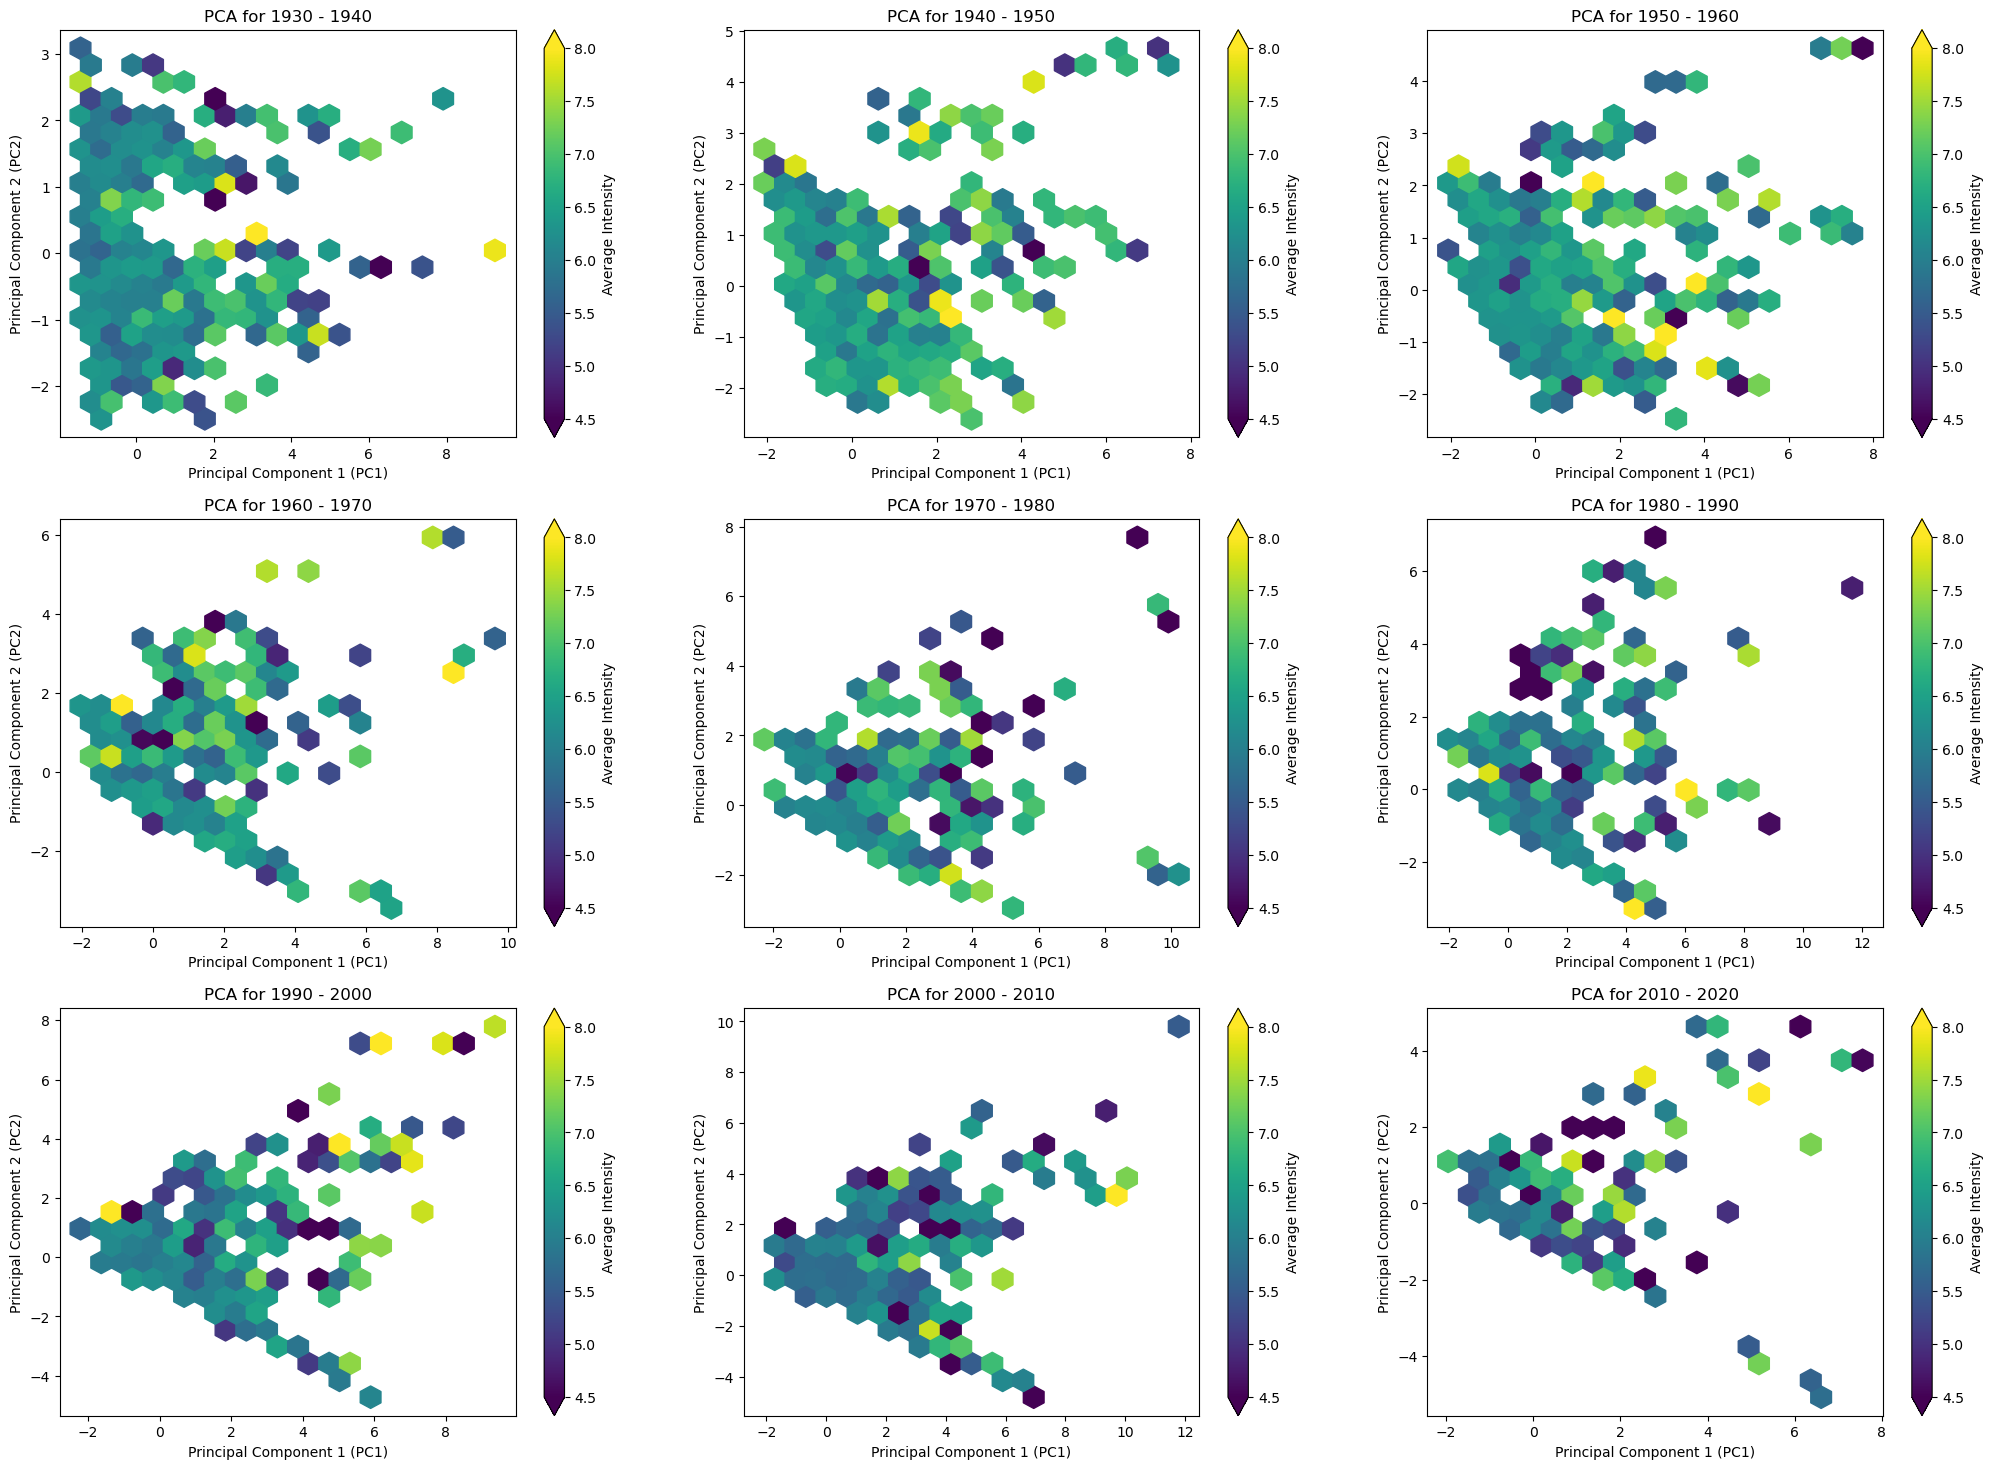

In [62]:
# - PCA (Emeline)
#     - lookout for clusters


figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    scaler = StandardScaler()
    # Apply dropna() before scaling to ensure matching indices
    non_null_data = Year[['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']].dropna()
    df_standardized = scaler.fit_transform(non_null_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)

    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    # Use non_null_data.index to ensure correct alignment of ratings
    df_pca['Rating'] = Year.loc[non_null_data.index, 'averageRating']
    
    # Set custom vmin and vmax values
    vmin = 4.5  # minimum value for the color scale
    vmax = 8    # maximum value for the color scale
    
    # Create a custom colormap
    colors_below_6_2 = plt.cm.viridis(np.linspace(0, 0.7, 256))
    colors_above_6_2 = plt.cm.inferno(np.linspace(0.7, 1, 256))
    colors_combined = np.vstack((colors_below_6_2, colors_above_6_2))
    custom_cmap = LinearSegmentedColormap.from_list('custom_colormap', colors_combined)
    
    # Create a hexbin plot with the custom colormap
    hexbin = axs[i].hexbin(df_pca['PC1'], df_pca['PC2'], C=df_pca['Rating'], gridsize=20, cmap='viridis', reduce_C_function=np.mean, vmin=vmin, vmax=vmax)


    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')
    plt.colorbar(hexbin, label='Average Intensity', extend='both')

    
plt.show()

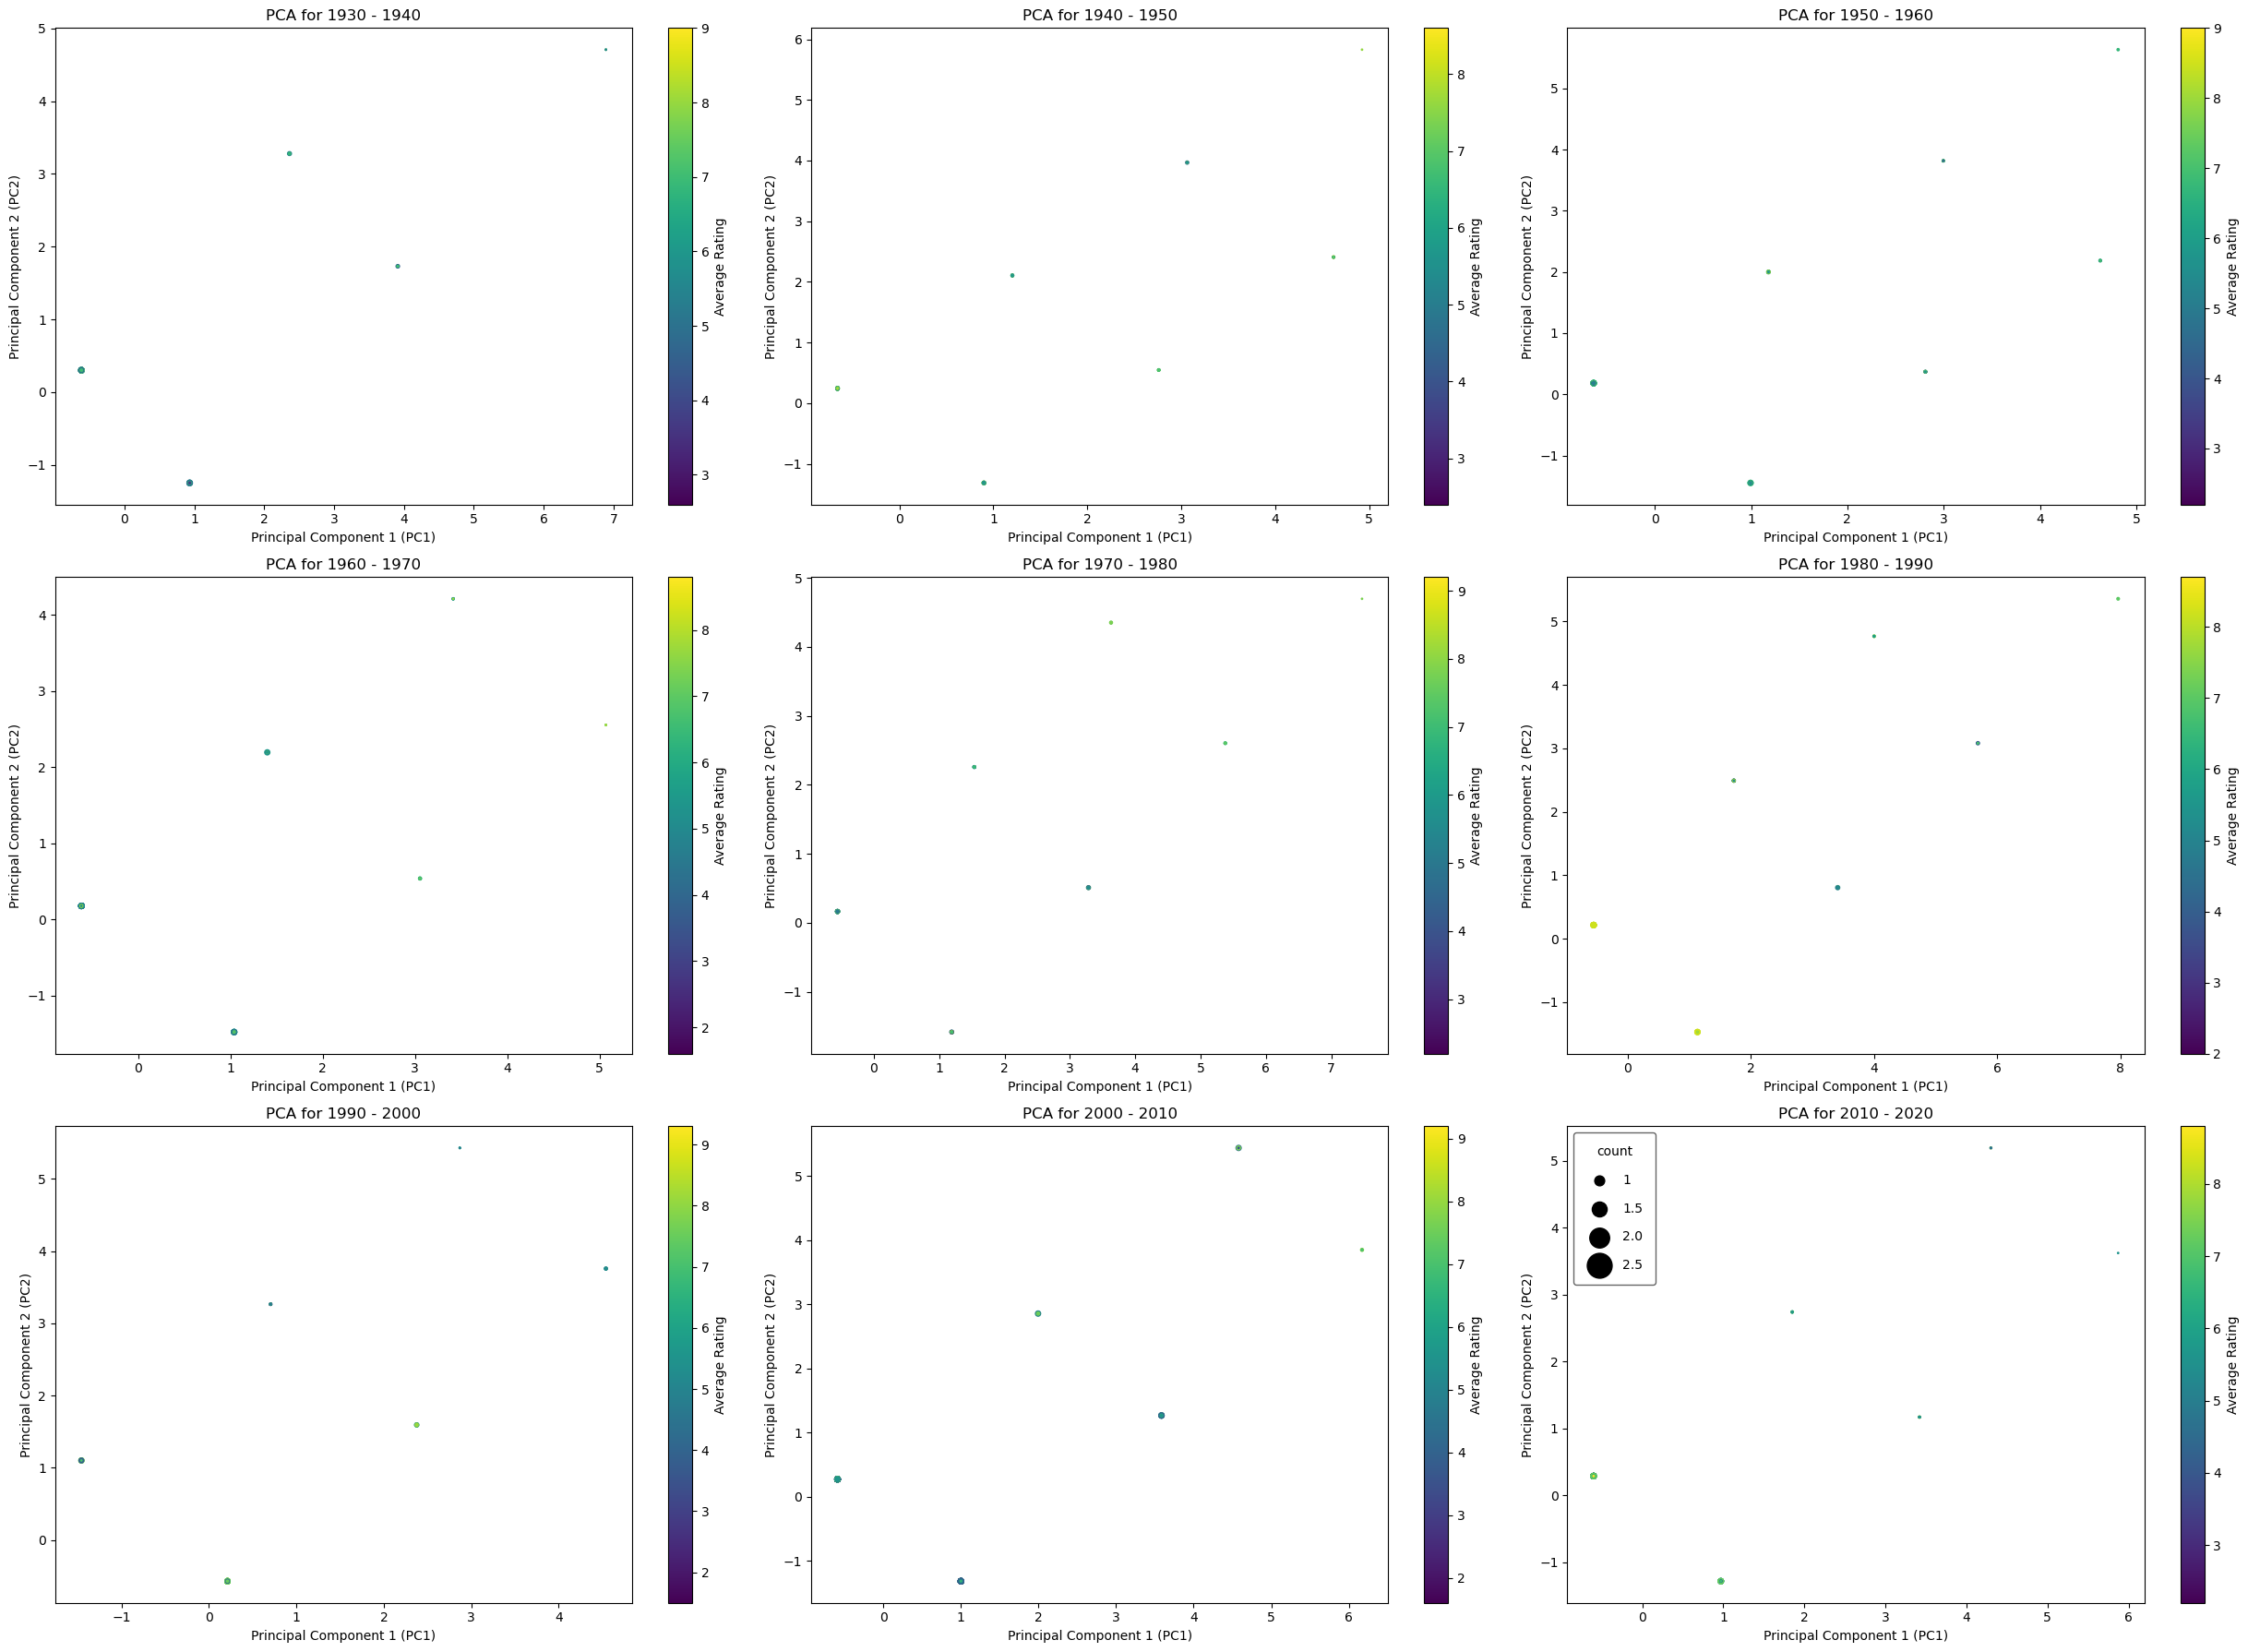

In [72]:
figs, axs = plt.subplots(3, 3, figsize=(25, 18))
axs = axs.flatten()
Years = actors_movies['ReleaseYearRange'].unique()

for i, year_range in enumerate(Years):
    Year = actors_movies[actors_movies['ReleaseYearRange'] == year_range]
    
    # Reset the index of Year to ensure alignment
    Year.reset_index(drop=True, inplace=True)

    # Group by attributes and count the number of actors in each group
    group_attributes = ['awards', 'nominations', 'movie_count', 'genres_b4', 'isMale', 'age_at_release']  # Add or modify as needed
    grouped = Year.groupby(group_attributes).size().reset_index(name='count')

    # Join the counts back to the original DataFrame
    Year = Year.merge(grouped, on=group_attributes, how='left')

    scaler = StandardScaler()
    non_null_data = Year[['isMale', 'awards']].dropna()
    df_standardized = scaler.fit_transform(non_null_data)
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df_standardized)

    # Create a DataFrame with the PCA results
    df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
    df_pca['Rating'] = Year.loc[non_null_data.index, 'averageRating']
    df_pca['Count'] = Year.loc[non_null_data.index, 'count']

    # Scatter plot with point sizes based on actor count
    scatter = axs[i].scatter(df_pca['PC1'], df_pca['PC2'], c=df_pca['Rating'], s=df_pca['Count'], cmap="viridis")
    axs[i].set_xlabel('Principal Component 1 (PC1)')
    axs[i].set_ylabel('Principal Component 2 (PC2)')
    axs[i].set_title(f'PCA for {year_range}')

    # Color bar for the scatter plot
    figs.colorbar(scatter, ax=axs[i], label='Average Rating')

#make a legend:
pws = [0.5, 1, 1.5, 2., 2.5]
for pw in pws:
    plt.scatter([], [], s=(pw**2)*60, c="k",label=str(pw))
    h, l = plt.gca().get_legend_handles_labels()
    plt.legend(h[1:], l[1:], labelspacing=1.2, title="count", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")


plt.tight_layout()
plt.show()


# Conclusion and future work